<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,The first murder scene is one of the best murd...,1
1,At the point in time that The Lady from Shangh...,1
2,The person who wrote the summary and rave revi...,0
3,Excellent example of the disaster that happens...,0
4,***SPOILERS*** ***SPOILERS*** HERE ON EARTH / ...,0


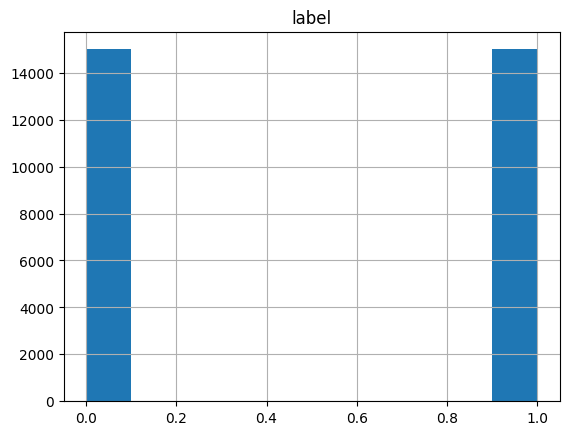

In [7]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This film deserves a 10 for its brilliant port...,1
1,...And I never thought a movie deserved to be ...,0
2,Let's put political correctness aside and just...,0
3,It's very sly for all of the 60's look to the ...,1
4,"""I'm a cartoon!"" ""You're an illustration!"" wha...",0


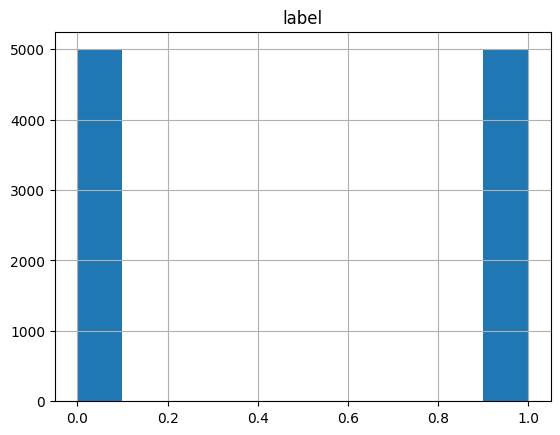

In [8]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,The film begins with Vincent Price about to be...,1
1,... and I have seen some bad ones.<br /><br />...,0
2,This movie was heavily marred by the presence ...,0
3,"I've seen a lot of Seagal movies, and while mo...",0
4,"""Yokai Daisenso"" is a children's film by Takas...",1


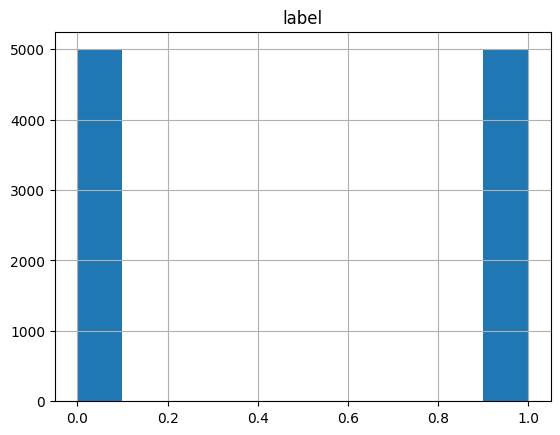

In [9]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [12]:
train = [str(item).lower() for item in  df_train["text"].values]
val = [str(item).lower() for item in  df_val["text"].values]
test = [str(item).lower() for item in  df_test["text"].values]

In [13]:
import numpy as np
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer

maxlen = 128
tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt", lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

X_train_bert = bert_tokenizer(train)
X_val_bert = bert_tokenizer(val)
X_test_bert = bert_tokenizer(test)

X_train_bert = tf.keras.preprocessing.sequence.pad_sequences(X_train_bert, maxlen=maxlen)
X_val_bert = tf.keras.preprocessing.sequence.pad_sequences(X_val_bert, maxlen=maxlen)
X_test_bert = tf.keras.preprocessing.sequence.pad_sequences(X_test_bert, maxlen=maxlen)

y_train = np.array(df_train["label"].values)
y_val = np.array(df_val["label"].values)
y_test = np.array(df_test["label"].values)

In [14]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
max_features = 30523

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, max_features, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

In [15]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 token_and_position_embeddin  (None, 128, 32)          980832    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 128, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0   

In [16]:
history = model.fit(X_train_bert, y_train, batch_size=32, epochs=2, validation_data=(X_val_bert, y_val))

Epoch 1/2
938/938 [==============================] - 42s 42ms/step - loss: 0.4053 - accuracy: 0.8063 - val_loss: 0.3479 - val_accuracy: 0.8432
Epoch 2/2
938/938 [==============================] - 40s 42ms/step - loss: 0.2441 - accuracy: 0.9001 - val_loss: 0.4313 - val_accuracy: 0.8284
